# TestCase 5

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from create_jsonfile import ask_user,read_config,check_config

# ask_user()
config = read_config(configfile="configs/config5.json")

### Configuration has been read from config.json ###
# dimension : 2
# testcase : 5
# version : 3
# error_estimations : {'param_num': 1}
# gains : {'n_params': 50}


In [3]:
dimension = config["dimension"]
testcase = config["testcase"]
version = config["version"]  
high_degree = 10

In [4]:
assert testcase == 5
check_config(config)

Config file is valid


## Imports + Load network

In [5]:
# export CUDA_VISIBLE_DEVICES=
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [6]:
from testcases.utils import create_tree

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
current_dir = os.getcwd()
repo_dir = os.path.dirname(current_dir)
repo_dir = os.path.dirname(repo_dir)
print(repo_dir)
# vérifier que repo_dir finit bien par "code" (à modifier pour l'utilisateur)
assert repo_dir.split("/")[-1] == "code"

/home/u2/lecourtier/Article1/code


In [8]:
testcase_dir = repo_dir + "/results/fenics/test_2D/testcase"+str(testcase)+"/version"+str(version)
if version == 1:
    from testcases.networks.test_2D.test_5.test_5_v1 import Run_laplacian2D,Poisson_2D
elif version == 2:
    from testcases.networks.test_2D.test_5.test_5_v2 import Run_laplacian2D,Poisson_2D 
elif version == 3:
    from testcases.networks.test_2D.test_5.test_5_v3 import Run_laplacian2D,Poisson_2D 
from testcases.problem.problem_2D import TestCase5
problem = TestCase5(version=version)

Using device: cpu
torch loaded; device is cpu


bigcenter :  [0.0, 0.0]
bigradius :  1.0
smallcenter :  [0.0, 0.0]
smallradius :  0.25
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
>> load network /home/u2/lecourtier/Article1/code/networks/test_2D/test_fe5_v3.pth
network loaded
Error  tensor([0.0328])


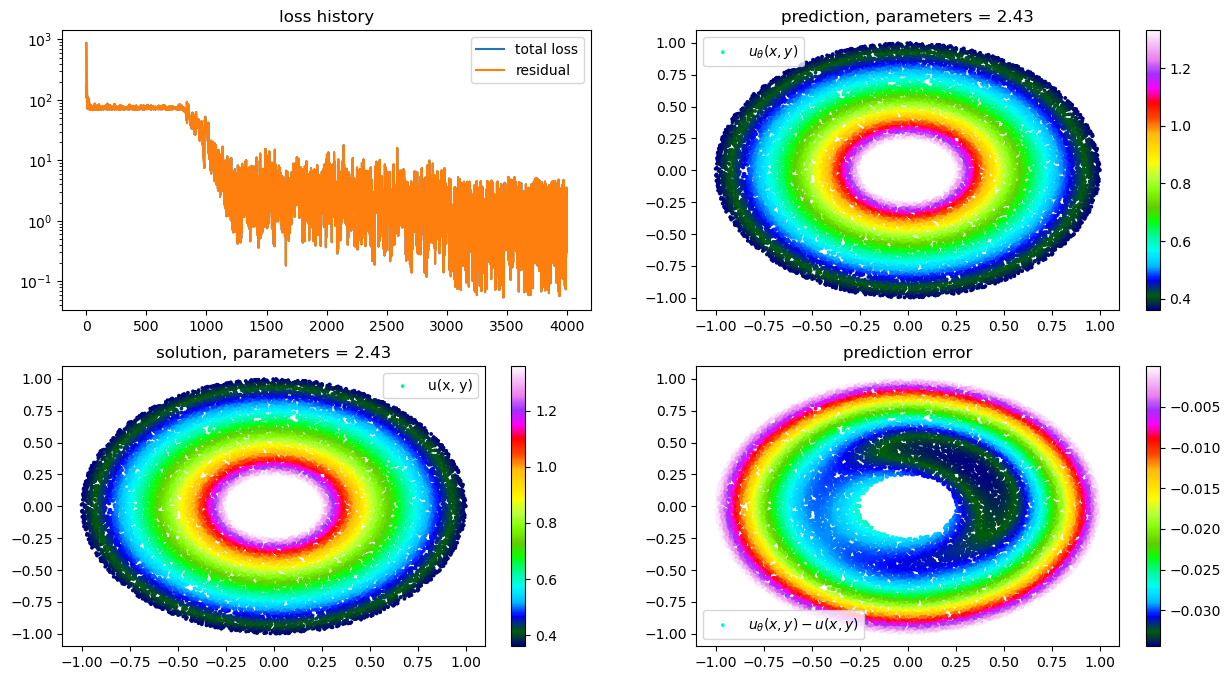

In [9]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

## Gains constant from Error estimations

In [10]:
deg_m = 0
assert deg_m == 0

In [52]:
import numpy as np
from scimba.equations.domain import SpaceTensor
from testcases.utils import select_param
import dolfin as df
import math
from IPython.display import Math, display
import mshr

N_ex = 200

def generate_mesh_given_size(domain, nb_vert):    
    box = np.array(problem.geometry.box)
    
    mesh_macro = df.RectangleMesh(df.Point(box[0,0], box[1,0]), df.Point(box[0,1], box[1,1]), nb_vert, nb_vert)
    h_macro = mesh_macro.hmax()
    H = 120
    mesh = mshr.generate_mesh(domain,H)
    h = mesh.hmax()
    while h > h_macro:
        H += 1
        mesh = mshr.generate_mesh(domain,H)
        h = mesh.hmax()
    
    return mesh

bigcenter = problem.geometry.bigcircle.center
bigradius = problem.geometry.bigcircle.radius
smallcenter = problem.geometry.hole.center
smallradius = problem.geometry.hole.radius

bigcircle = mshr.Circle(df.Point(bigcenter[0],bigcenter[1]), bigradius)
hole = mshr.Circle(df.Point(smallcenter[0],smallcenter[1]), smallradius)
domain = bigcircle-hole

mesh_ex = generate_mesh_given_size(domain, N_ex)
     
V_ex = df.FunctionSpace(mesh_ex, "CG", 4)
dx_ex = df.Measure("dx", domain=mesh_ex)
print(mesh_ex.hmax())

0.014084078953959871


In [53]:
XXYY = V_ex.tabulate_dof_coordinates()#.reshape(-1,1)
print(XXYY.shape)

param_num = config["error_estimations"]["param_num"]    
params = [select_param(problem,param_num)]
print(params)

X_test = torch.tensor(XXYY,requires_grad=True)
X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

# get parameters
nb_params = len(trainer.pde.parameter_domain)
shape = (XXYY.shape[0],nb_params)
ones = torch.ones(shape)
mu_test = (torch.Tensor(params[0]).to(device) * ones).to(device)

u_ex = pde.reference_solution(X_test, mu_test).cpu().detach().numpy()[:,0]
du_ex_dx, du_ex_dy = pde.reference_solution_derivative(X_test, mu_test)
du_ex_dx = du_ex_dx.cpu().detach().numpy()[:,0]
du_ex_dy = du_ex_dy.cpu().detach().numpy()[:,0]
d2u_ex_dx2, d2u_ex_dxy, d2u_ex_dy2 = pde.reference_solution_second_derivative(X_test, mu_test)
d2u_ex_dx2 = d2u_ex_dx2.cpu().detach().numpy()[:,0]
d2u_ex_dxy = d2u_ex_dxy.cpu().detach().numpy()[:,0]
d2u_ex_dy2 = d2u_ex_dy2.cpu().detach().numpy()[:,0]

pred = u_theta.setup_w_dict(X_test, mu_test)
u_theta.get_first_derivatives(pred, X_test)
u_theta.get_second_derivatives(pred, X_test)
        
u_theta_ = pred["w"][:,0].cpu().detach().numpy()
u_theta_x = pred["w_x"][:,0].cpu().detach().numpy()
u_theta_y = pred["w_y"][:,0].cpu().detach().numpy()
u_theta_xx = pred["w_xx"][:,0].cpu().detach().numpy()
u_theta_xy = pred["w_xy"][:,0].cpu().detach().numpy()
u_theta_yy = pred["w_yy"][:,0].cpu().detach().numpy()

(598064, 2)
[array([2.51])]


In [54]:
# Solutions
u_fe = df.Function(V_ex)
u_fe.vector()[:] = u_ex

u_theta_fe = df.Function(V_ex)
u_theta_fe.vector()[:] = u_theta_

# First derivatives
dudx_fe = df.Function(V_ex)
dudx_fe.vector()[:] = du_ex_dx

du_dy_fe = df.Function(V_ex)
du_dy_fe.vector()[:] = du_ex_dy

duthetadx_fe = df.Function(V_ex)
duthetadx_fe.vector()[:] = u_theta_x

duthetady_fe = df.Function(V_ex)
duthetady_fe.vector()[:] = u_theta_y

# Second derivatives
d2udx2_fe = df.Function(V_ex)
d2udx2_fe.vector()[:] = d2u_ex_dx2

d2udxy_fe = df.Function(V_ex)
d2udxy_fe.vector()[:] = d2u_ex_dxy

d2udy2_fe = df.Function(V_ex)
d2udy2_fe.vector()[:] = d2u_ex_dy2

d2uthetadx2_fe = df.Function(V_ex)
d2uthetadx2_fe.vector()[:] = u_theta_xx

d2uthetadxy_fe = df.Function(V_ex)
d2uthetadxy_fe.vector()[:] = u_theta_xy

d2uthetady2_fe = df.Function(V_ex)
d2uthetady2_fe.vector()[:] = u_theta_yy

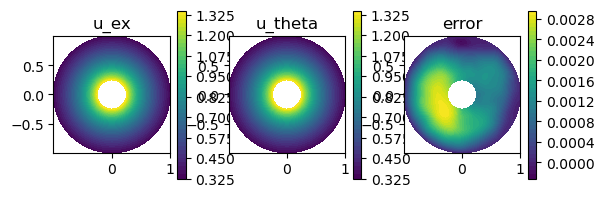

In [41]:
# import matplotlib.pyplot as plt
# plt.figure()

# plt.subplot(2, 3, 1)
# c = df.plot(u_fe)
# plt.colorbar(c)
# plt.title("u_ex")

# plt.subplot(2, 3, 2)
# c = df.plot(u_theta_fe)
# plt.colorbar(c)
# plt.title("u_theta")

# plt.subplot(2, 3, 3)
# error = df.Function(V_ex)
# error.vector()[:] = u_fe.vector() - u_theta_fe.vector()
# c = df.plot(error)
# plt.colorbar(c)
# plt.title("error")

# plt.show()

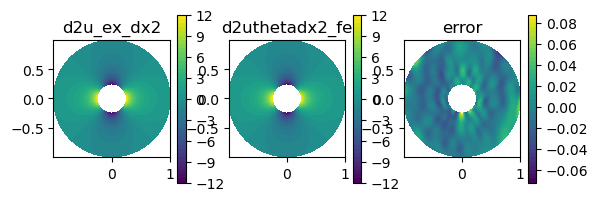

In [42]:
# import matplotlib.pyplot as plt
# plt.figure()

# plt.subplot(2, 3, 1)
# c = df.plot(d2udx2_fe)
# plt.colorbar(c)
# plt.title("d2u_ex_dx2")

# plt.subplot(2, 3, 2)
# c = df.plot(d2uthetadx2_fe)
# plt.colorbar(c)
# plt.title("d2uthetadx2_fe")

# plt.subplot(2, 3, 3)
# error = df.Function(V_ex)
# error.vector()[:] = d2udx2_fe.vector() - d2uthetadx2_fe.vector()
# c = df.plot(error)
# plt.colorbar(c)
# plt.title("error")

# plt.show()

### Add

$$C_\text{\rm gain}^+= \frac{| u-u_{\theta} |_{H^{q+1}}}{| u |_{H^{q+1}}}$$

In [59]:
seminormH2 = df.assemble(((d2udx2_fe - d2uthetadx2_fe) ** 2 + (d2udxy_fe - d2uthetadxy_fe) ** 2 + (d2udy2_fe - d2uthetady2_fe) ** 2) * dx_ex) ** (0.5)
seminormH2_rel = df.assemble((d2udx2_fe ** 2 + d2udxy_fe ** 2 + d2udy2_fe ** 2) * dx_ex) ** (0.5)
c_gain_add = seminormH2 / seminormH2_rel
coeff = math.factorial(deg_m) / math.factorial(deg_m//2)**2
cvg = coeff * c_gain_add

display(Math(r"$m = " + f"{deg_m}$" + r" ; $\frac{m!}{\lfloor \frac{m}{2} \rfloor!^2} = " + f"{coeff}$"))
display(Math(r"$C_\text{gain}^+ = " + f"{c_gain_add}$"))
display(Math(r"$\frac{m!}{\lfloor \frac{m}{2} \rfloor!^2}C_\text{gain}^+ = " + f"{cvg}$"))
display(Math(r"$1/C_\text{gain}^+ = " + f"{1/c_gain_add}$"))
display(Math(r"$\frac{1}{\frac{m!}{\lfloor \frac{m}{2} \rfloor!^2}C_\text{gain}^+} = " + f"{1/cvg}$"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Error estimations

### Imports

In [10]:
from modfenics.error_estimations.error_estimations import ErrorEstimations
from modfenics.error_estimations.compare import CompareMethods

/home/u2/lecourtier/miniconda3/envs/fenics_scimba_modules/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [11]:
param_num = config["error_estimations"]["param_num"]     
error_estimations = ErrorEstimations(param_num, problem, repo_dir = repo_dir)
compare_methods = CompareMethods(error_estimations)
tab_nb_vert = error_estimations.tab_nb_vert

## Results directory: /home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/cvg/param1/


### Run FEM

In [12]:
degree = 1
df_FEM, tab_h_FEM, tab_err_FEM = error_estimations.run_fem_deg(degree,new_run=False)

## Run error estimation with FEM for degree=1
V_ex created with  501  vertices and degree  4  : h_ex = 0.005633800733210699
V created with  16  vertices and degree  1  : h = 0.16660094771444728
V_theta created with  16  vertices and degree  10
Building point search tree to accelerate distance queries.
Computed bounding box tree with 1053 nodes for 527 points.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 929281 nodes for 464641 points.
nb_vert=16, norme_L2=0.04482641357402933
V created with  32  vertices and degree  1  : h = 0.08694977804807888
V_theta created with  32  vertices and degree  10
Building point search tree to accelerate distance queries.
Computed bounding box tree with 3893 nodes for 1947 points.
nb_vert=32, norme_L2=0.0013801282371567682
V created with  64  vertices and degree  1  : h = 0.04347576862597117
V_theta created with  64  vertices and degree  10
Building point search tree to accelerate distance queries.
Computed boun

## Read csv file : /home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/cvg/param1/FEM_case5_v3_param1_degree1.csv
## Run error estimation with FEM for degree=2
V_ex created with  501  vertices and degree  4  : h_ex = 0.005633800733210699
V created with  16  vertices and degree  2  : h = 0.16660094771444728
V_theta created with  16  vertices and degree  10
Building point search tree to accelerate distance queries.
nb_vert=16, norme_L2=0.003388073736462855
Computed bounding box tree with 1053 nodes for 527 points.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 929281 nodes for 464641 points.
V created with  32  vertices and degree  2  : h = 0.08694977804807888
V_theta created with  32  vertices and degree  10
Building point search tree to accelerate distance queries.
Computed bounding box tree with 3893 nodes for 1947 points.
nb_vert=32, norme_L2=5.408787096135018e-05
V created with  64  vertices and degree  2  : h = 0.0

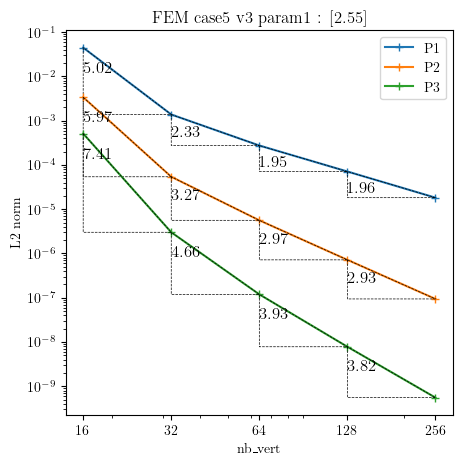

In [13]:
error_estimations.run_fem_alldeg(new_run=False,plot_cvg=True)

### Run Add

In [14]:
degree = 3
df_Corr, tab_h_Corr, tab_err_Corr = error_estimations.run_corr_deg(degree,u_theta,new_run=False)

## Run error estimation with Corr for degree=3
V_ex created with  501  vertices and degree  4  : h_ex = 0.005633800733210699
V created with  16  vertices and degree  3  : h = 0.16660094771444728
V_theta created with  16  vertices and degree  10
Building point search tree to accelerate distance queries.
Computed bounding box tree with 1053 nodes for 527 points.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 929281 nodes for 464641 points.
nb_vert=16, norme_L2=3.946856145816531e-06
V created with  32  vertices and degree  3  : h = 0.08694977804807888
V_theta created with  32  vertices and degree  10
Building point search tree to accelerate distance queries.
Computed bounding box tree with 3893 nodes for 1947 points.
nb_vert=32, norme_L2=1.1784321878029338e-07
V created with  64  vertices and degree  3  : h = 0.04347576862597117
V_theta created with  64  vertices and degree  10
Building point search tree to accelerate distance queries.
Computed 

## Run error estimation with Corr for degree=1
V_ex created with  501  vertices and degree  4  : h_ex = 0.005633800733210699
V created with  16  vertices and degree  1  : h = 0.16660094771444728
V_theta created with  16  vertices and degree  10
Building point search tree to accelerate distance queries.
Computed bounding box tree with 1053 nodes for 527 points.
Building point search tree to accelerate distance queries.
nb_vert=16, norme_L2=0.00014356069979247447
Computed bounding box tree with 929281 nodes for 464641 points.
V created with  32  vertices and degree  1  : h = 0.08694977804807888
V_theta created with  32  vertices and degree  10
Building point search tree to accelerate distance queries.
Computed bounding box tree with 3893 nodes for 1947 points.
nb_vert=32, norme_L2=2.526643254524458e-05
V created with  64  vertices and degree  1  : h = 0.04347576862597117
V_theta created with  64  vertices and degree  10
Building point search tree to accelerate distance queries.
Computed 

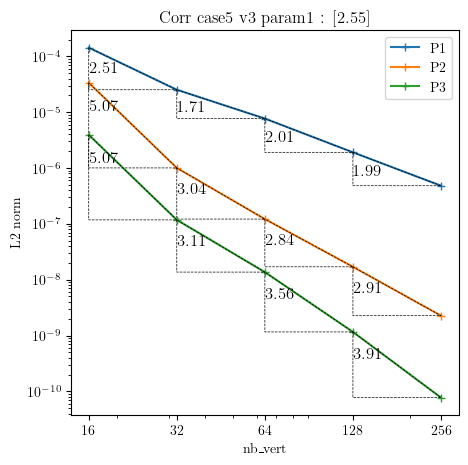

In [15]:
error_estimations.run_corr_alldeg(u_theta,new_run=False,plot_cvg=True)

### Save results

/home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/cvg/param1/FEM_case5_v3_param1_degree1.csv
/home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/cvg/param1/FEM_case5_v3_param1_degree2.csv
/home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/cvg/param1/FEM_case5_v3_param1_degree3.csv


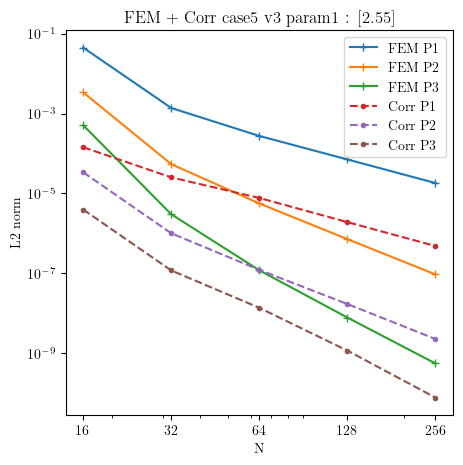

In [16]:
compare_methods.plot_Corr_vs_FEM_alldeg()

In [17]:
compare_methods.save_tab_alldeg_allM()

/home/u2/lecourtier/Article1/code/src/modfenics/error_estimations/compare.py:198: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[error_cols] = df[error_cols].applymap(lambda x: f'{x:.2e}')
/home/u2/lecourtier/Article1/code/src/modfenics/error_estimations/compare.py:202: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[factor_cols] = df[factor_cols].applymap(lambda x: f'{round(x,2)}')
/home/u2/lecourtier/Article1/code/src/modfenics/error_estimations/compare.py:198: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[error_cols] = df[error_cols].applymap(lambda x: f'{x:.2e}')
/home/u2/lecourtier/Article1/code/src/modfenics/error_estimations/compare.py:202: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[factor_cols] = df[factor_cols].applymap(lambda x: f'{round(x,2)}')
/home/u2/lecourtier/Article1/code/src/modfenics/error_estimations/comp

## Gains

### Imports

In [18]:
from modfenics.gains.gains import GainsEnhancedFEM
from modfenics.gains.compare import CompareGainsMethods

In [19]:
n_params = config["gains"]["n_params"]   
gains_enhanced_fem = GainsEnhancedFEM(n_params, problem, repo_dir = repo_dir)
compare_gains_methods = CompareGainsMethods(gains_enhanced_fem)

## Results directory: /home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/gains/


### Run FEM

In [20]:
degree = 1
df_FEM, tab_h_FEM, tab_err_FEM = gains_enhanced_fem.run_fem_deg(degree,new_run=False)

## Run errrors with FEM for degree=1
V_ex created with  501  vertices and degree  4  : h_ex = 0.005633800733210699
nb_vert=20
V created with  20  vertices and degree  1  : h = 0.13306504232756408
V_theta created with  20  vertices and degree  10
0 Building point search tree to accelerate distance queries.
1 Computed bounding box tree with 1687 nodes for 844 points.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 929281 nodes for 464641 points.
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 nb_vert=40
V created with  40  vertices and degree  1  : h = 0.06895360018243568
V_theta created with  40  vertices and degree  10
0 Building point search tree to accelerate distance queries.
Computed bounding box tree with 6353 nodes for 3177 points.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 4

In [21]:
gains_enhanced_fem.run_fem_alldeg(new_run=False)

## Read csv file : /home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/gains/FEM_errors_case5_v3_degree1.csv
## Run errrors with FEM for degree=2
V_ex created with  501  vertices and degree  4  : h_ex = 0.005633800733210699
nb_vert=20
V created with  20  vertices and degree  2  : h = 0.13306504232756408
V_theta created with  20  vertices and degree  10
0 Building point search tree to accelerate distance queries.
1 Computed bounding box tree with 1687 nodes for 844 points.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 929281 nodes for 464641 points.
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 nb_vert=40
V created with  40  vertices and degree  2  : h = 0.06895360018243568
V_theta created with  40  vertices and degree  10
0 Building point search tree to accelerate distance queries.
Computed bounding box tree with 6353 nodes for 3

### Run PINNs

In [22]:
degree = 1
df_PINNs, tab_h_PINNs, tab_err_PINNs = gains_enhanced_fem.run_pinns_deg(degree,u_theta,new_run=False)

## Run errrors with PINNs for degree=1
V_ex created with  501  vertices and degree  4  : h_ex = 0.005633800733210699
nb_vert=20
V created with  20  vertices and degree  1  : h = 0.13306504232756408
V_theta created with  20  vertices and degree  10
0 Building point search tree to accelerate distance queries.
1 Computed bounding box tree with 929281 nodes for 464641 points.
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 nb_vert=40
V created with  40  vertices and degree  1  : h = 0.06895360018243568
V_theta created with  40  vertices and degree  10
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [23]:
gains_enhanced_fem.run_pinns_alldeg(u_theta,new_run=False)

## Read csv file : /home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/gains/PINNs_errors_case5_v3_degree1.csv
## Run errrors with PINNs for degree=2
V_ex created with  501  vertices and degree  4  : h_ex = 0.005633800733210699
nb_vert=20
V created with  20  vertices and degree  2  : h = 0.13306504232756408
V_theta created with  20  vertices and degree  10
0 Building point search tree to accelerate distance queries.
1 Computed bounding box tree with 929281 nodes for 464641 points.
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 nb_vert=40
V created with  40  vertices and degree  2  : h = 0.06895360018243568
V_theta created with  40  vertices and degree  10
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 ## Run errrors with PINNs for degree=3
V_ex created with  501  vertices and degree 

### Run Add

In [24]:
degree = 1
df_Corr, tab_h_Corr, tab_err_Corr = gains_enhanced_fem.run_corr_deg(degree,u_theta,new_run=False)

## Run errrors with Corr for degree=1
V_ex created with  501  vertices and degree  4  : h_ex = 0.005633800733210699
nb_vert=20
V created with  20  vertices and degree  1  : h = 0.13306504232756408
V_theta created with  20  vertices and degree  10
0 Building point search tree to accelerate distance queries.
Computed bounding box tree with 1687 nodes for 844 points.
1 Building point search tree to accelerate distance queries.
Computed bounding box tree with 929281 nodes for 464641 points.
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 nb_vert=40
V created with  40  vertices and degree  1  : h = 0.06895360018243568
V_theta created with  40  vertices and degree  10
0 Building point search tree to accelerate distance queries.
Computed bounding box tree with 6353 nodes for 3177 points.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 

In [25]:
gains_enhanced_fem.run_corr_alldeg(u_theta,new_run=False)

## Read csv file : /home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/gains/Corr_errors_case5_v3_degree1.csv
## Run errrors with Corr for degree=2
V_ex created with  501  vertices and degree  4  : h_ex = 0.005633800733210699
nb_vert=20
V created with  20  vertices and degree  2  : h = 0.13306504232756408
V_theta created with  20  vertices and degree  10
0 Building point search tree to accelerate distance queries.
Computed bounding box tree with 1687 nodes for 844 points.
1Building point search tree to accelerate distance queries.
 Computed bounding box tree with 929281 nodes for 464641 points.
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 nb_vert=40
V created with  40  vertices and degree  2  : h = 0.06895360018243568
V_theta created with  40  vertices and degree  10
0 Building point search tree to accelerate distance queries.
Computed bounding box tree with 6353 nodes for

### Compare methods

In [26]:
degree = 1
# df_errors = compare_gains_methods.create_dferrors_deg_allM(degree)
df_gains = compare_gains_methods.create_dataframes_deg_allM(degree)

/home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/gains/FEM_errors_case5_v3_degree1.csv


In [27]:
compare_gains_methods.create_dataframes_alldeg_allM()

/home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/gains/FEM_errors_case5_v3_degree1.csv
/home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/gains/FEM_errors_case5_v3_degree2.csv
/home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/gains/FEM_errors_case5_v3_degree3.csv


In [28]:
df_stats = compare_gains_methods.save_stats_deg_allM(degree)

/home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/gains/FEM_errors_case5_v3_degree1.csv
method          PINNs                          FEM                     
type              min     max    mean    std   min    max   mean    std
method n_vert                                                          
Corr   20       50.90  172.89  164.70  23.65  2.94  91.46  16.14  20.04
       40      181.64  638.01  606.71  88.88  2.77  83.40  15.05  18.39


/home/u2/lecourtier/Article1/code/src/modfenics/gains/compare.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_stats_round = df_stats.applymap(lambda x: f"{x:.2f}")


In [29]:
compare_gains_methods.save_stats_alldeg_allM()

/home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/gains/FEM_errors_case5_v3_degree1.csv
method          PINNs                          FEM                     
type              min     max    mean    std   min    max   mean    std
method n_vert                                                          
Corr   20       50.90  172.89  164.70  23.65  2.94  91.46  16.14  20.04
       40      181.64  638.01  606.71  88.88  2.77  83.40  15.05  18.39


/home/u2/lecourtier/Article1/code/src/modfenics/gains/compare.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_stats_round = df_stats.applymap(lambda x: f"{x:.2f}")


/home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/gains/FEM_errors_case5_v3_degree2.csv
method           PINNs                                 FEM                \
type               min       max      mean       std   min    max   mean   
method n_vert                                                              
Corr   20       657.09   6252.70   5497.20   1330.48  5.72  64.38  22.23   
       40      4012.30  46826.74  39987.31  10415.75  5.64  51.75  20.53   

method                
type             std  
method n_vert         
Corr   20      16.18  
       40      13.49  


/home/u2/lecourtier/Article1/code/src/modfenics/gains/compare.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_stats_round = df_stats.applymap(lambda x: f"{x:.2f}")


/home/u2/lecourtier/Article1/code/results/fenics/test_2D/testcase5/version3/gains/FEM_errors_case5_v3_degree3.csv
method            PINNs                                       FEM         \
type                min         max        mean        std    min    max   
method n_vert                                                              
Corr   20       3521.15   169582.05   100060.47   50904.86  11.59  25.34   
       40      34662.28  2391948.03  1163424.83  694193.18  10.63  16.29   

method                      
type            mean   std  
method n_vert               
Corr   20      20.22  4.43  
       40      14.21  1.86  


/home/u2/lecourtier/Article1/code/src/modfenics/gains/compare.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_stats_round = df_stats.applymap(lambda x: f"{x:.2f}")
